# Week 11: In-Class Assignment: <br> Manifold Learning

### <p style="text-align: right;"> &#9989; Kyle Taft
<p style="text-align: right;"> &#9989; Jacob, Lucas, Daniel

![mds_lle](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.10-LLE-vs-MDS.png)


This ICA is due at **11:59PM today**.

#### Goals of this assignment 

In this ICA you will explore two very different methods for Non-Linear Dimensionality Reduction [NLDR](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Hessian_Locally-Linear_Embedding_(Hessian_LLE)): 
* Multidimensional Scaling [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling), 
* Local Linear Embedding [LLE](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Locally-linear_embedding). 

Since you are teaching yourself manifold learning techniques, read a bit about these so that you have a bit of intuition for what they do.

# Part 1: Make CMSE

We will first make a dataset using an image that we create. Of course, we could use the [`make_s_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html) or [`make_swiss_roll`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html) in `sklearn`, but that's less fun! 

Let's make our own shapes! You can make your own custom datasets from PNG images. You don't need to understand how the next few cells work, but feel free to read through them if you want to use this idea in your other projects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set_context("notebook")


In [2]:
# We will make our data from an image. This function makes a PNG file, 
# reads it back in and makes a dataset from it. (Idea credit: Jake Vanderplos)

def make_cmse(N=100, rseed=42):

    # Make a PNG file with "CMSE!!" text.
    fig, ax = plt.subplots(figsize=(5, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'Kyle :)', va='center', ha='center', weight='bold', size=60)
    fig.savefig('cmse.png')
    plt.close(fig)
    
    # Next, with the PNG made, read the image in to make data from it. 
    # imread docs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imread.html
    img = imread('cmse.png')
    data = img[::-1, :, 1].T 
    # Create a random number generator
    rng = np.random.RandomState(42)
    # Create 4*N uniform random points in the range [0 to 1)
    X = rng.rand(4 * N, 2)
    # Create two arrays of N elements whose values correspond to indices in the image matrix. 
    # Try printing the max and min values of i and j to see what they are.
    i, j = (X * data.shape).astype(int).T
    # Find 4*N values in the image matrix that are less than a little more than the minimum (i.e. black color)
    mask = (data[i, j] < data.min() + 0.1)

    # create the dataset from the image
    X = X[mask]
    # aspect ratio
    X[:, 0] *= (data.shape[0] / data.shape[1])
    # Select only the first N points
    X = X[:N]

    return X[np.argsort(X[:, 0])]

With that function, we can create our dataset.

Here is the image that was made:


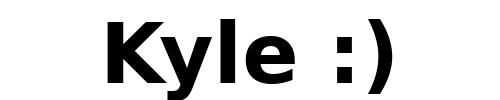

In [3]:
X = make_cmse(2000)

print("Here is the image that was made:")

from IPython.display import Image
Image("cmse.png")


Here is the dataset made from that image:


C:\Users\2003k\AppData\Local\Temp\ipykernel_13452\734041931.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('terrain', 6))


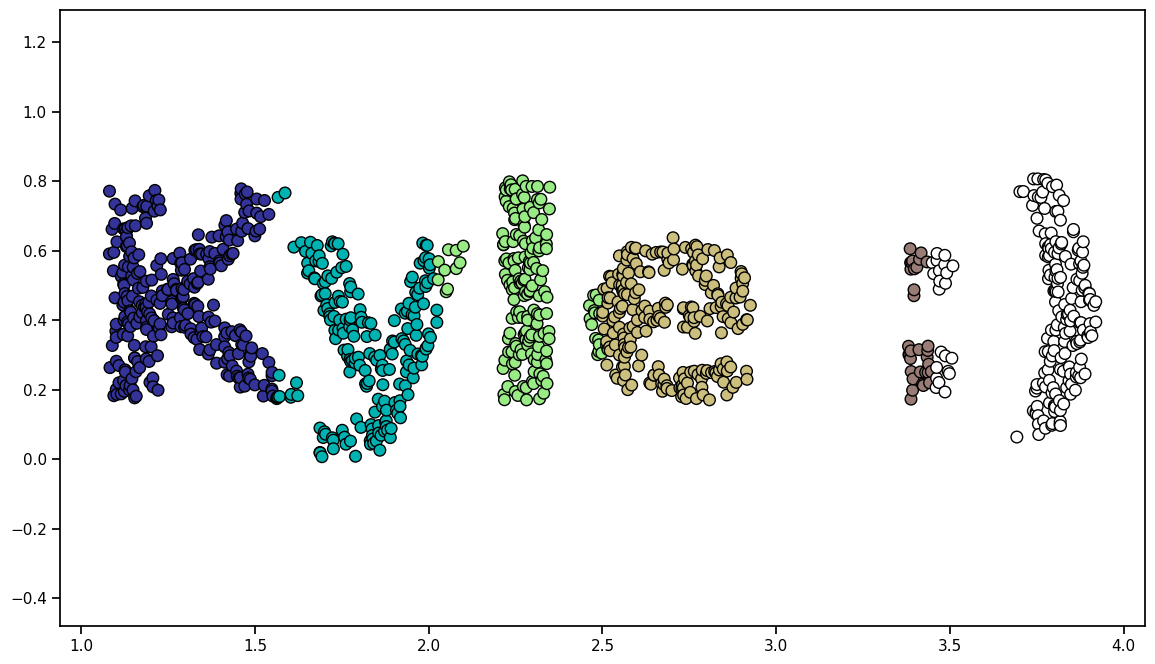

In [4]:
print("Here is the dataset made from that image:")
# set up **kwargs to control the color pattern
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('terrain', 6))
# use the color pattern dictionary to show the "data"
fig = plt.figure(figsize=(14,8))
plt.scatter(X[:, 0], X[:, 1], s=70, edgecolors='black', **colorize)
plt.axis('equal');

# Part 2: Data Transformation

There is a lot we can do with this dataset now. For example, let's define some transformations of the data. I am putting transformation functions here in one place, but we will refer back to these as we go through the notebook. For now, just make a mental note of what is here and what the name of the data variable is. 

Feel free to play with these now, or wait until we need them.

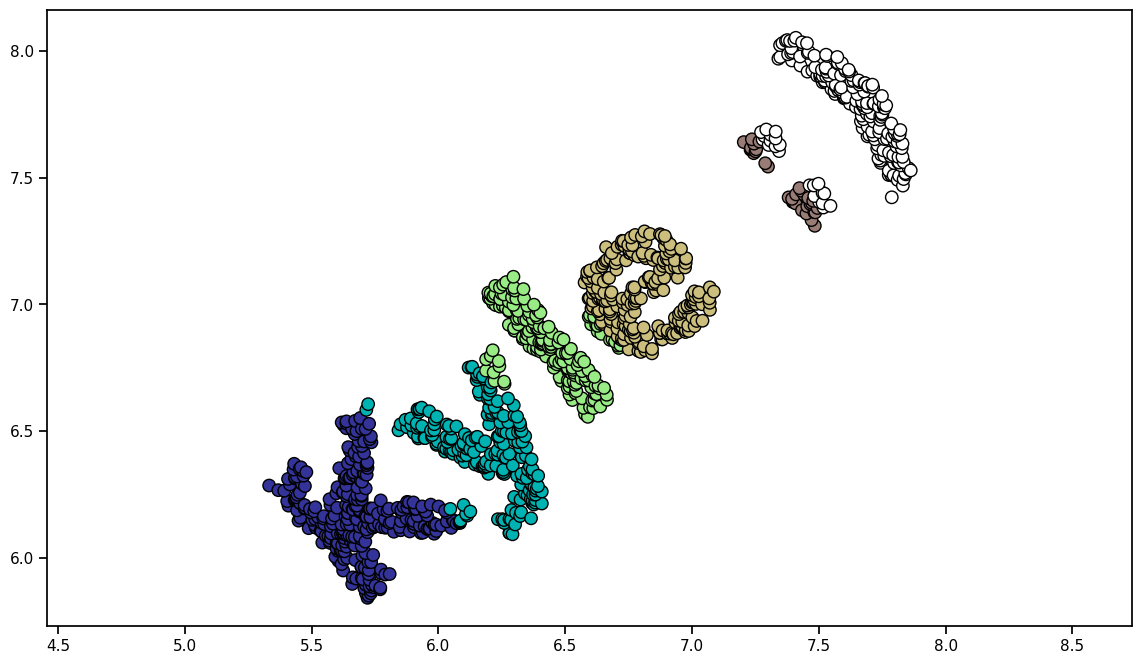

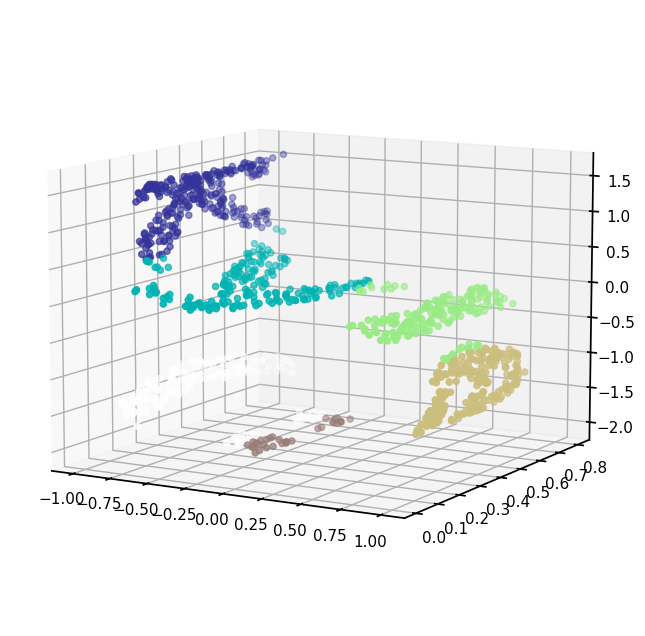

In [5]:
# rotation in 2D
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 40) + 5
fig = plt.figure(figsize=(14,8))
plt.scatter(X2[:, 0], X2[:, 1], s=80, edgecolors='black', **colorize)
plt.axis('equal');

# rotation in 3D
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
# X3.shape

# s curve
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

# Fold the data onto itself to make the S curve.
XS = make_hello_s_curve(X)
# Try plotting it.
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)
ax.view_init(10, -60);


Why did we make these functions? The scaling and orientation of the data should not be important: we should find the shape of the data under **any** rotation or stretching. Let's see if it works...

What is important? Typically, we think in terms of these two types:
1. some notion of distance (e.g., Euclidean, geodesic) 
2. some notion of similarity. 

Of course, we want to choose definitions of these types ourselves, especially in the case of similarity, because that can mean very different things in different contexts.

Let's try similarity. Looking at the two previous datasets (unrotated and rotated), what needs to be similar? Clearly it is not the angle. However, the distances between each of the points has stayed the same. Pick a point in the C and and point in the E - those two points are still the same distance apart. 

&#9989; **Do This:** Comment this code and describe in a markdown cell what the `pairwise_distances` library does. Comment on why we would want the algorithm to be independent of rotations. Exactly what quantities should be independent of rotations? 

Read [this](https://scikit-learn.org/stable/modules/metrics.html#metrics) to help.

Error in callback <function _draw_all_if_interactive at 0x000001C267201F30> (for post_execute):


KeyboardInterrupt: 

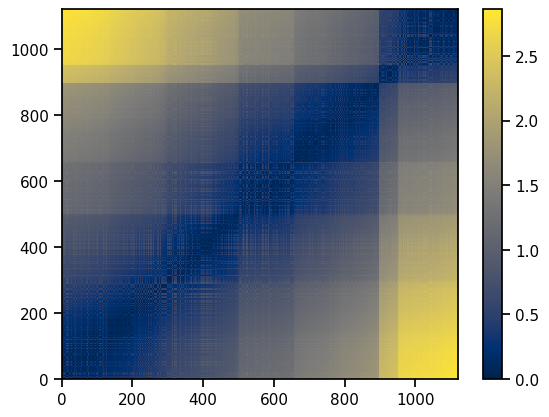

In [6]:
from sklearn.metrics import pairwise_distances
X_distances_eucl = pairwise_distances(X, metric='euclidean') # Calculate euclidean distance

fig, ax = plt.subplots(1,1)
p = ax.pcolormesh(X_distances_eucl, cmap = 'cividis') # Plots the distance matrix as a color map
fig.colorbar(p)


Pairwise distances is a function that takes in a set of points and returns a matrix of distances between each point determined by a certain distance metric. In this case, we are using the Euclidean distance metric. We want the algorithm to be independent of rotations because we want the distances between points to be the same regardless of the orientation of the data.

&#9989; **Do This:** Now, compute the distance matrix for the _rotated_ data. Compare the distance matrix for the two datasets. Make an image, for example, of the difference between the two distance matrices and comment on your results. 

You might also see if [this](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) library can help. 

**The distance matrix for the rotated data is the same as the distance matrix for the unrotated data. This is because the distance between each point is the same regardless of the orientation of the data.**

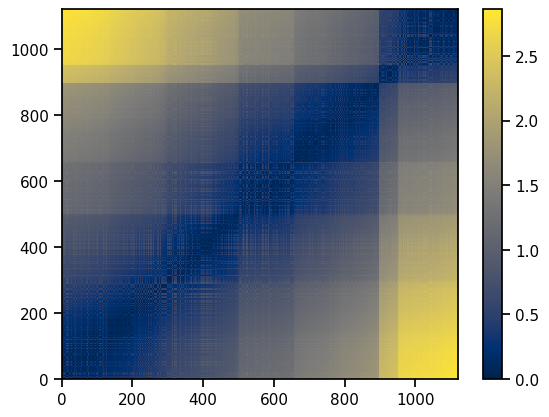

In [ ]:
# Put your code here
X_distances_eucl = pairwise_distances(X2, metric='euclidean') # Calculate euclidean distance

fig, ax = plt.subplots(1,1)
p = ax.pcolormesh(X_distances_eucl, cmap = 'cividis') # Plots the distance matrix as a color map
fig.colorbar(p)

# Part 3: Multi Dimensional Scaling (MDS)
If you wanted you could use the distance matrix you just computed - it contains all of the information that you need! (Or, you could choose another definition.) As is, however, it isn't an obvious solution to any problem. **What manifold learning attempts to do is create data using a similarity measure**; in this case, we have the distances. Let's use this information in MDS to see if it can reconstruct the data just from these "similarities"! 


&#9989; **Do This:**

* Comment this code. For example, how is it using the distances we explored above? 
* Run the code several times to see if the results change from run to run.
* Time the code for different numbers of points in the dataset and make a plot of time versus number of points in the dataset. 
* Vary the `random_state` to see what that does.
* Comment on all of your results.

**Warning:** not much happens for this case. But, be sure to understand what is happening here before things get interesting. You will need to run it several times until you see the point.

In [ ]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import time

In [ ]:
times = []
for comps in np.arange(1, 100, 10):
    # Defines the model with 2 components
    model_eucl = MDS(n_components=comps, dissimilarity='precomputed', n_jobs = -1, random_state=1)
    # Fits the model to the euclid data
    start = time.time()
    out_eucl = model_eucl.fit_transform(X_distances_eucl)
    end = time.time()
    times.append(end-start)
    print('Time to fit: ', end - start)

# # Plot the results
# plt.scatter(out_eucl[:,0], out_eucl[:,1], c = X[:,0], cmap = 'terrain')


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  8.533574104309082


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  12.609377145767212


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  11.2435302734375


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  11.377111196517944


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  12.462475776672363


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  12.45535159111023


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  12.620479345321655


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  17.384703159332275


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  14.230717420578003


C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Time to fit:  19.34532141685486


Text(0.5, 1.0, 'Components for MDS vs. Time to Fit')

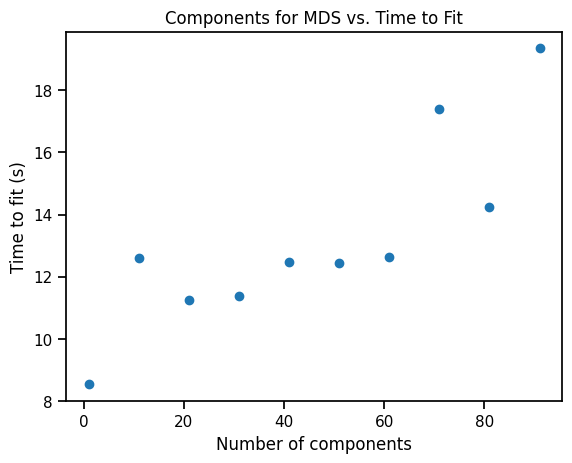

In [ ]:
plt.scatter(np.arange(1, 100, 10), times)
plt.xlabel('Number of components')
plt.ylabel('Time to fit (s)')
plt.title("Components for MDS vs. Time to Fit")

---
## 3D Projections
Hopefully the above code built a little intuition for MDS. Let's take that, perhaps overly simple, example to the next most simple case: 3D. 

[Text(0.5, 0, '$X_1$'), Text(0.5, 0.5, '$X_2$'), Text(0.5, 0, '$X_3$')]

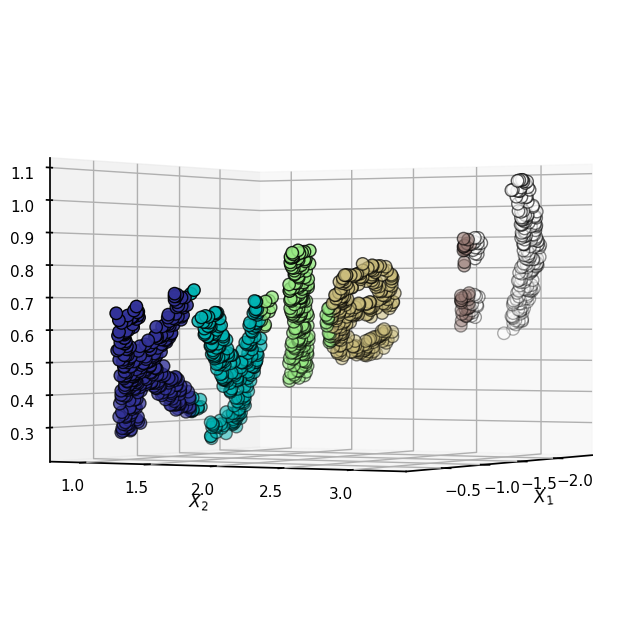

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], s=80, edgecolors='black', **colorize)
ax.view_init(azim=30, elev=0)
ax.set(xlabel = r"$X_1$", ylabel = r"$X_2$", zlabel = r"$X_3$")

&#9989; **Do This:** Comment this code very carefully and describe what it does. 

C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(-1.6281114212272032,
 1.3975087178457573,
 -1.0817580110252476,
 0.8442086305977814)

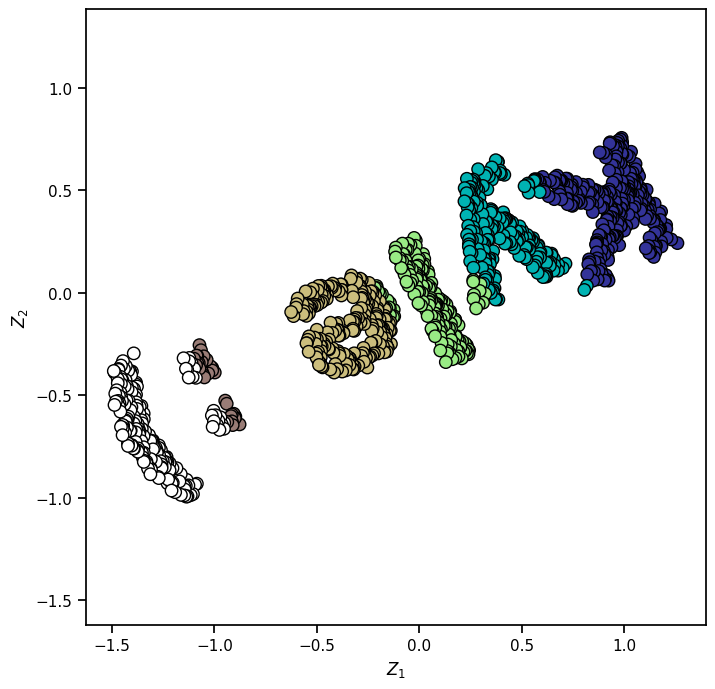

In [ ]:
model = MDS(n_components=2, random_state=1) # 2 components so we can plot it
out3 = model.fit_transform(X3) # fit using the random projection data

fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(out3[:, 0],  out3[:, 1], s=80, edgecolors='black', **colorize)
ax.set(xlabel = r"$Z_1$", ylabel = r"$Z_2$")
ax.axis('equal')


Now, the fun begins! 

The data so far was subjected to linear operations: rotations in 2D and 3D. And, the similarity we used was distances. When all of the data lives in a plane, which is preserved in these transformations, we saw the distances are preserved. What happens if the transformation is *nonlinear* and the distances become....let's say...._more interesting_? 

Earlier we made a third dataset called `XS` - let's take a look at it.

[Text(0.5, 0, '$Y_1$'), Text(0.5, 0.5, '$Y_2$'), Text(0.5, 0, '$Y_3$')]

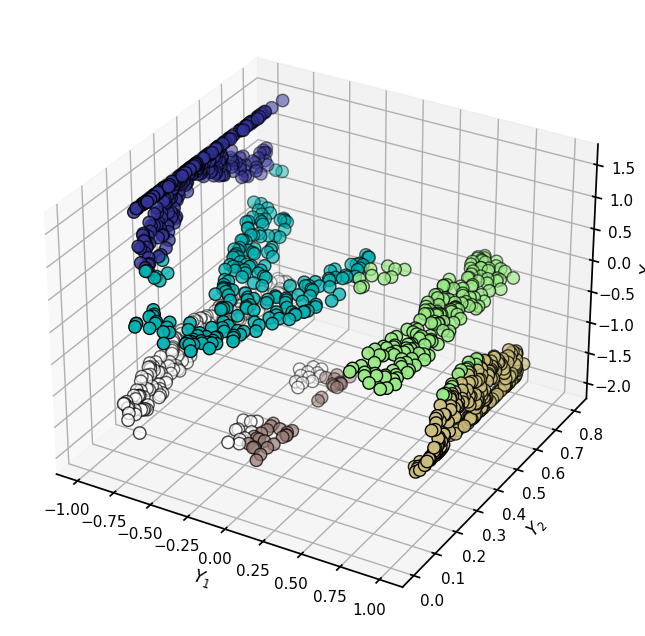

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], s=80, edgecolors='black', **colorize)
ax.set(xlabel = r"$Y_1$", ylabel = r"$Y_2$", zlabel = r"$Y_3$")


&#9989; **Do This:** Now, think about this: if we computed the distances between the points for this version of the dataset, what outcome would you expect? 

You now know how to run MDS. Take _this_ 3D data and move it to 2D using MDS and see what you get. Explain what you see; what did MDS do? For a bit of a hint, see the image at the very top of this notebook. 

What is your conclusion about MDS?

Here is some helper code to get you started:

C:\Users\2003k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


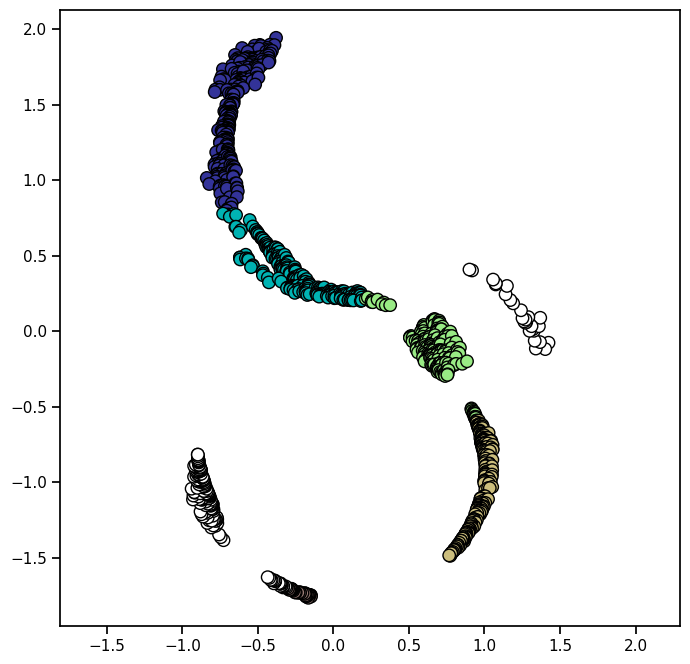

In [ ]:
model = MDS(n_components=2, random_state=1) # note the number of components
out_s = model.fit_transform(XS) # note which data is used

fig = plt.figure(figsize=(8,8))
plt.scatter(out_s[:, 0],  out_s[:, 1], s=80, edgecolors='black', **colorize)
plt.axis('equal');

# Part 4: Locally Linear Embedding

MDS does exactly what we tell it to do, which is to preserve the distances - _all of them_! 

LLE takes a different approach, which is to "think globally, act locally". We want to preserve the manifold, but we want to preserve **local** relationships on the manifold, just for the reasons that MDS "failed". 

&#9989; **Do This:** Run all of the data through LLE to explore how it differs from MDS. In particular, vary the number of neighbors. Also, rerun the notebook with different sequences of symbols (like your name!) to see if you see trends. 

[Text(0.5, 0, '$Z_1$'), Text(0, 0.5, '$Z_2$')]

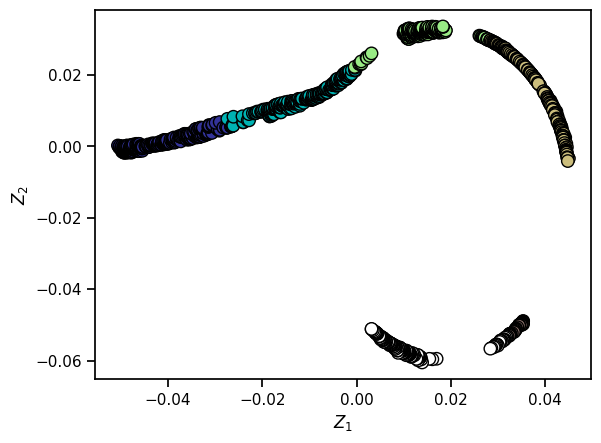

In [7]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=500, 
                               n_components=2, 
                               method='modified',
                               eigen_solver='dense')
lle_out = model.fit_transform(XS)


fig, ax = plt.subplots(1,1)
ax.scatter(lle_out[:, 0], lle_out[:, 1], s=80, edgecolors='black', **colorize)
ax.set(xlabel = r"$Z_1$", ylabel = r"$Z_2$")


&#9989; **Question:** After using each of the datasets with different LLE hyperparameter choices, discsuss what behaviors you saw and how that compares with MDS. What are the pros and cons of each?

The number of neighbors seems to be an important hyperparameter to determine our results. As we increase the number of neighbors we good more of a structure to our data. The pros of MDS is that it is simple and easy to understand. The cons of MDS is that it is not very flexible and it is not very good at preserving global structure. The pros of LLE is that it is good at preserving global structure. The cons of LLE is that it is more complex and it is not as good at preserving local structure.


&#169; Copyright 2023, Department of Computational Mathematics, Science and Engineering at Michigan State University.